In [1]:
import pandas as pd
import numpy as np


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
!pip install catboost
from catboost import Pool, CatBoostClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

!pip install shap
import shap

from hyperopt import fmin, hp, tpe

import matplotlib.pyplot as plt
import seaborn as sns


     |████████████████████████████████| 76.1 MB 49 kB/s 
     |████████████████████████████████| 564 kB 4.3 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_df = pd.read_csv('/content/drive/MyDrive/Ensemble Learning/all_features.csv', index_col=0)
train_df = train_df.sample(frac=1,random_state=1).reset_index(drop=True)

In [4]:
train_df['not_cyberbullying'] = (train_df.cyberbullying_type == "not_cyberbullying").astype(int)
train_df.head(5)

,tweet_text,cyberbullying_type,characters per tweet,words per tweet,nb_upper,nb_lower,nb_capitalized,mixed_upper_lower_not_capitalized,nb_len_1,nb_len_2,...,gay,round,good,radical,bad,mkr,rape,stupid,lot,not_cyberbullying
0,"FYI the phrase is ""out your RABID mind"" dumb f...",ethnicity,85,16,2,14,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,U are Still scared to call out Jihad Still sca...,religion,283,54,2,42,8,0,7,8,...,0,0,0,0,0,0,0,0,0,0
2,"You can read Gibbon on Rome, Thucydides on Ath...",religion,284,50,0,36,12,0,2,9,...,0,0,0,0,0,0,0,0,0,0
3,I was never bullied. But in gr11 the popular g...,age,277,57,3,50,3,0,6,17,...,0,0,1,0,0,0,0,0,0,0
4,My dream is for one of the girls who bullied m...,age,274,59,0,55,4,0,1,14,...,0,0,0,0,0,0,0,0,0,0


In [5]:
train_df['not_cyberbullying'].value_counts()

0    39747
1     7945
Name: not_cyberbullying, dtype: int64

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
matrix = vectorizer.fit_transform(train_df.tweet_text)

X = matrix
y = train_df['not_cyberbullying']

In [7]:
from sklearn.model_selection import train_test_split
from collections import Counter

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)
print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")

Training target statistics: Counter({0: 27797, 1: 5587})
Testing target statistics: Counter({0: 11950, 1: 2358})


In [12]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
#!pip install scikit-plot
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_cumulative_gain
from scikitplot.metrics import plot_lift_curve

from numpy import argmax
import numpy as np

def build_and_test(X_tr, X_te, y_tr, y_te, class_weight = None, threshold=False):
    
    # Build and Plot PCA
    #pca = PCA(n_components=2)
    #pca.fit(X_tr.toarray())
    #X_pca = pca.transform(X_tr.toarray())

    #plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_tr, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
    #plt.show()
    
    # Build and fit the model
    if class_weight:
      
        model = CatBoostClassifier(iterations=1000,
        random_strength=1, #set to one to prevent overfitting
        depth=6, #relatively low to prevent overfitting
        l2_leaf_reg=2, #from grid search
        border_count=32, #from grid search
        rsm=1, #from grid search
        eval_metric ='Accuracy',
        class_weights = class_weight, 
        boosting_type = 'Plain',
        silent=True)
    else:
        model = CatBoostClassifier(iterations=1000,
        random_strength=1, 
        depth=6, 
        l2_leaf_reg=2, 
        border_count=32, #from grid search
        rsm=1, #from grid search
        eval_metric='Accuracy',
        boosting_type = 'Plain',
        silent=True)
    model.fit(X_tr, y_tr)

    # Test the model
    y_pred = model.predict(X_te)
    print('Precision score %s' % precision_score(y_te, y_pred))
    print('Recall score %s' % recall_score(y_te, y_pred))
    print('F1-score score %s' % f1_score(y_te, y_pred))
    print('Accuracy score %s' % accuracy_score(y_te, y_pred))
    
    y_score = model.predict_proba(X_te)
    fpr0, tpr0, thresholds = roc_curve(y_te, y_score[:, 1])
    roc_auc0 = auc(fpr0, tpr0)
    
    # Calculate the best threshold
    best_threshold = None
    if threshold:
        J = tpr0 - fpr0
        ix = argmax(J) # take the value which maximizes the J variable
        best_threshold = thresholds[ix]
        # adjust score according to threshold.
        y_score = np.array([[1, y[1]] if y[0] >= best_threshold else [0, y[1]] for y in y_score])
        
    # Plot metrics 
    plot_roc(y_te, y_score)
    plt.show()
    
    plot_precision_recall(y_te, y_score)
    plt.show()
    
    plot_cumulative_gain(y_te, y_score)
    plt.show()
    
    plot_lift_curve(y_te, y_score)
    plt.show()
    
    # Print a classification report
    print(classification_report(y_te,y_pred))
    return roc_auc0,fpr0,tpr0, best_threshold
        
    
    

Precision score 0.7489251934651763
Recall score 0.3693808312128923
F1-score score 0.49474581084919056
Accuracy score 0.8756639642158233


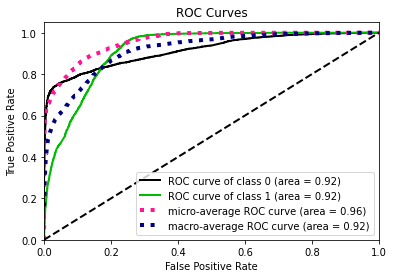

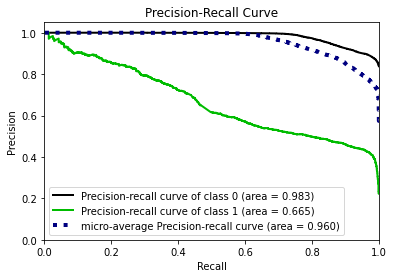

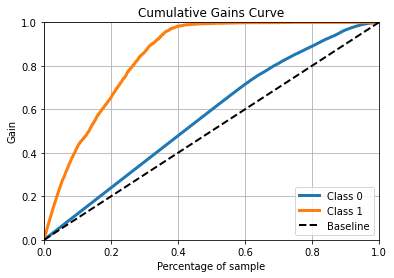

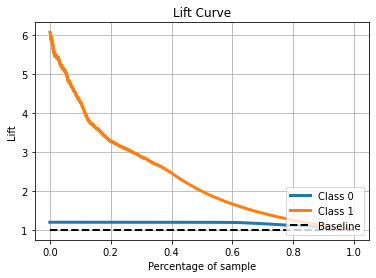

              precision    recall  f1-score   support

           0       0.89      0.98      0.93     11950
           1       0.75      0.37      0.49      2358

    accuracy                           0.88     14308
   macro avg       0.82      0.67      0.71     14308
weighted avg       0.86      0.88      0.86     14308



In [13]:
#Firstly, I calculate the performance of the imbalanced dataset, as it is
roc_auc_imb,fpr_imb,tpr_imb, _ = build_and_test(X_train, X_test, y_train, y_test)

In [14]:
#Oversampling
from imblearn.over_sampling import RandomOverSampler
over_sampler = RandomOverSampler(random_state=42)
X_res, y_res = over_sampler.fit_resample(X_train, y_train)
print(f"Training target statistics: {Counter(y_res)}")
print(f"Testing target statistics: {Counter(y_test)}")

Training target statistics: Counter({1: 27797, 0: 27797})
Testing target statistics: Counter({0: 11950, 1: 2358})


Precision score 0.4634355565086854
Recall score 0.9164546225614928
F1-score score 0.6155818259507193
Accuracy score 0.8113642717360917


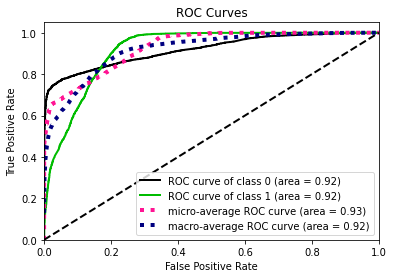

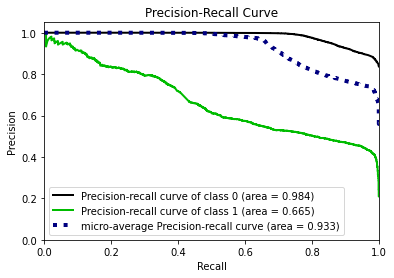

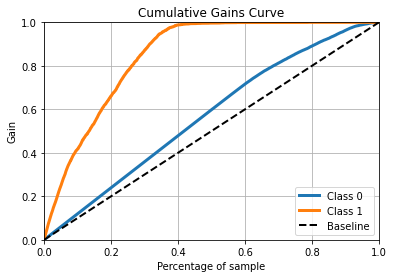

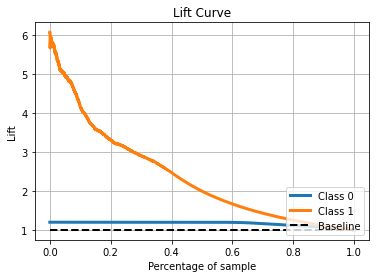

              precision    recall  f1-score   support

           0       0.98      0.79      0.88     11950
           1       0.46      0.92      0.62      2358

    accuracy                           0.81     14308
   macro avg       0.72      0.85      0.75     14308
weighted avg       0.89      0.81      0.83     14308



In [15]:
roc_auc_ros,fpr_ros,tpr_ros, _ = build_and_test(X_res, X_test, y_res, y_test)

In [16]:
#undersample the big dataset 
from imblearn.under_sampling import RandomUnderSampler

under_sampler = RandomUnderSampler(random_state=42)
X_res, y_res = under_sampler.fit_resample(X_train, y_train)
print(f"Training target statistics: {Counter(y_res)}")
print(f"Testing target statistics: {Counter(y_test)}")

Training target statistics: Counter({0: 5587, 1: 5587})
Testing target statistics: Counter({0: 11950, 1: 2358})


Precision score 0.4486785494775661
Recall score 0.9287531806615776
F1-score score 0.6050559469539992
Accuracy score 0.8001817165222254


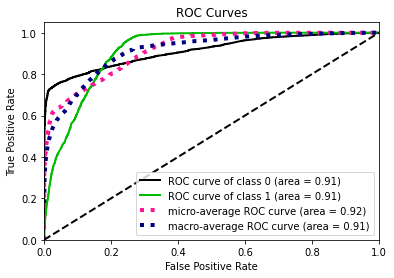

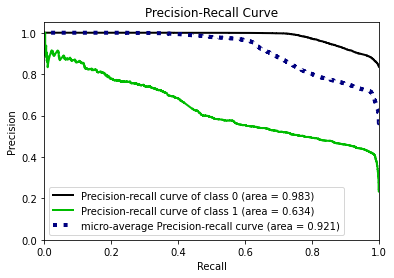

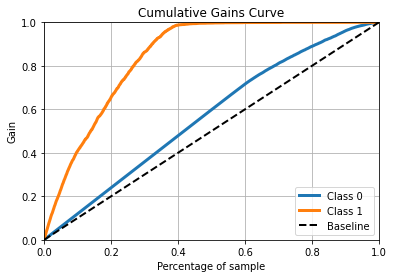

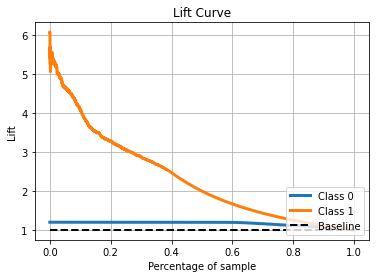

              precision    recall  f1-score   support

           0       0.98      0.77      0.87     11950
           1       0.45      0.93      0.61      2358

    accuracy                           0.80     14308
   macro avg       0.72      0.85      0.74     14308
weighted avg       0.89      0.80      0.82     14308



In [17]:
roc_auc_rus,fpr_rus,tpr_rus , _ = build_and_test(X_res, X_test, y_res, y_test)

Training target statistics: Counter({0: 5587, 1: 5587})
Testing target statistics: Counter({0: 11950, 1: 2358})
Precision score 0.4507462686567164
Recall score 0.8965224766751484
F1-score score 0.5998864926220204
Accuracy score 0.8029074643556052


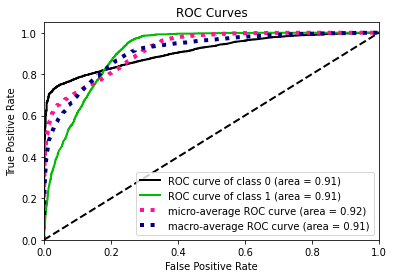

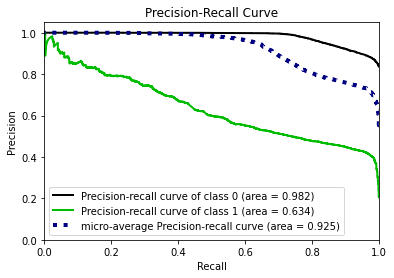

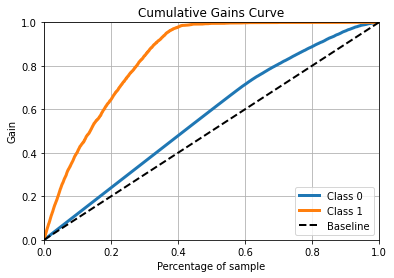

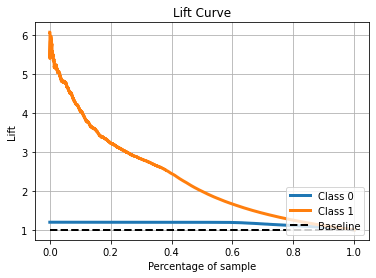

              precision    recall  f1-score   support

           0       0.97      0.78      0.87     11950
           1       0.45      0.90      0.60      2358

    accuracy                           0.80     14308
   macro avg       0.71      0.84      0.73     14308
weighted avg       0.89      0.80      0.82     14308



In [18]:
#Same analysis, another tool

from imblearn.under_sampling import NearMiss

under_sampler = NearMiss()
X_res, y_res = under_sampler.fit_resample(X_train, y_train)
print(f"Training target statistics: {Counter(y_res)}")
print(f"Testing target statistics: {Counter(y_test)}")

roc_auc_nm,fpr_nm,tpr_nm, _  = build_and_test(X_res, X_test, y_res, y_test)

In [10]:
#Using class_weight
n= Counter(y_train)
ratio = int(n[0]/n[1])
ratio, n

(4, Counter({0: 27797, 1: 5587}))

In [26]:
!pip install scikit-learn==0.18 --force-reinstall

     |████████████████████████████████| 8.9 MB 7.1 MB/s 
  ERROR: Failed building wheel for scikit-learn
  Running setup.py clean for scikit-learn
Failed to build scikit-learn
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
    Running setup.py install for scikit-learn ... error
  Rolling back uninstall of scikit-learn
  Moving to /usr/local/lib/python3.7/dist-packages/scikit_learn-1.0.2.dist-info/
   from /usr/local/lib/python3.7/dist-packages/~cikit_learn-1.0.2.dist-info
  Moving to /usr/local/lib/python3.7/dist-packages/scikit_learn.libs/
   from /usr/local/lib/python3.7/dist-packages/~cikit_learn.libs
  Moving to /usr/local/lib/python3.7/dist-packages/sklearn/
   from /usr/local/lib/python3.7/dist-packages/~klearn
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-ins

Precision score 0.4677491103202847
Recall score 0.8918575063613231
F1-score score 0.6136562591187628
Accuracy score 0.8149287112105116


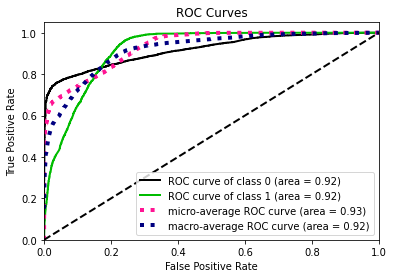

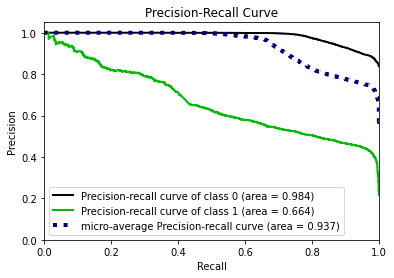

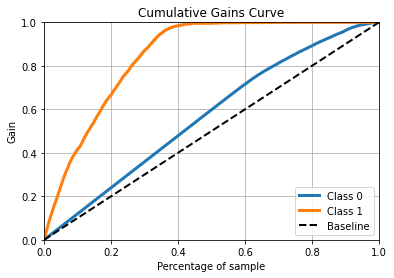

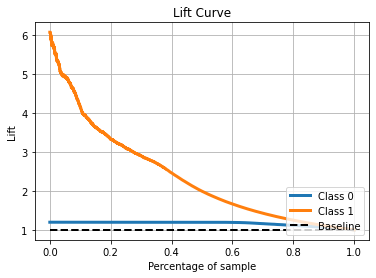

              precision    recall  f1-score   support

           0       0.97      0.80      0.88     11950
           1       0.47      0.89      0.61      2358

    accuracy                           0.81     14308
   macro avg       0.72      0.85      0.75     14308
weighted avg       0.89      0.81      0.83     14308



ValueError: ignored

In [13]:
roc_auc_cw,fpr_cw,tpr_cw  = build_and_test(X_train, X_test, y_train, y_test, class_weight={0:1, 1:ratio})

Precision score 0.7489251934651763
Recall score 0.3693808312128923
F1-score score 0.49474581084919056
Accuracy score 0.8756639642158233


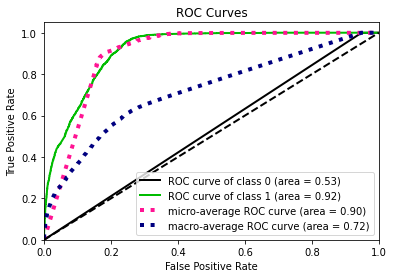

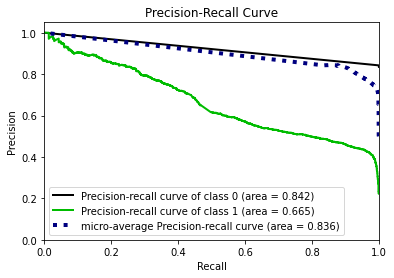

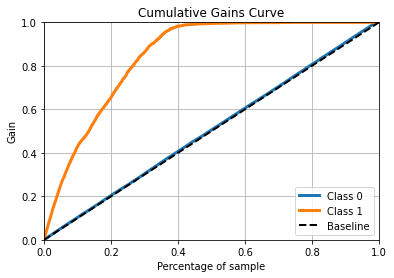

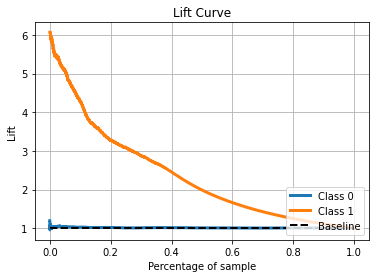

              precision    recall  f1-score   support

           0       0.89      0.98      0.93     11950
           1       0.75      0.37      0.49      2358

    accuracy                           0.88     14308
   macro avg       0.82      0.67      0.71     14308
weighted avg       0.86      0.88      0.86     14308

Best Treshold: 0.1528792296015756


In [14]:
roc_auc_thr,fpr_thr,tpr_thr, threshold = build_and_test(X_train, X_test, y_train, y_test, threshold=True)
print(f"Best Treshold: {threshold}")